# Drugi domaći zadatak iz predmeta 13E044DOS - Digitalna obrada slike
<hr>
<p style="font-size:20px">Viktor Todosijević 0050/2017</p>

## Prvi zadatak
<hr>

Automatsko numerisanje jednačina

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from skimage.feature.peak import peak_local_max
from skimage.exposure import rescale_intensity
from matplotlib.patches import Circle
import time
from IPython.display import clear_output


%matplotlib inline

from IPython.display import display, HTML

HTML centriranje plotova

In [3]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.

Euklidsko rastojanje u tački $(u, v)$ kvadrirano<br>
\begin{equation} \label{euclid_distance}
D^2(u, v) = {u^2 + v^2}
\end{equation}


In [4]:
def distance_sqrd(X, Y, xx, yy):
    D = ((X - xx) ** 2 + (Y - yy) ** 2)
    D = D.astype(np.float32)
    return D

Notch filtar - nepropusnik određenog niza opsega. Svaki član filtra je tipa ili idealnog ili Batervortovog ili Gausovog visokofrekventnog filtra.

In [5]:
def notch_filter(filter_name, peaks, height, width, radius, D0, order):
    
    H = np.ones((height, width))
    min_dist = 50
    for i in range(len(peaks)):
        # skip DC
        if np.abs(peaks[i, 0] - Q / 2) < min_dist and np.abs(
                peaks[i, 1] - P / 2) < min_dist:
            continue

        D_sqrd = distance_sqrd(X, Y, peaks[i, 1], peaks[i, 0])

        if filter_name == 'ideal':
            H[D_sqrd < radius**2] = 0

        if filter_name == 'gauss':
            H[D_sqrd < radius ** 2] = H[D_sqrd < radius ** 2] * (1 - np.exp(-D_sqrd[D_sqrd < radius ** 2] / 2 / D0 ** 2))

        if filter_name == 'butter':
            H[D_sqrd < radius ** 2] = H[D_sqrd < radius ** 2] * (1 - 1 / (1 + D_sqrd[D_sqrd < radius ** 2] ** order / D0 ** (2 * order)))
        
        clear_output(wait=True)
        print(i, " / ", len(peaks), end="\r")

    H[H < 0] = 0
    return H

Niskofrekventni filtri<br>

Neka je $D(u, v)$ euklidsko rastojanje od koordinatnog početka u tački $(u, v)$ dato formulom (\ref{euclid_distance}). Tada su formule implementiranih  niskofrekventinih filtara sledeće:


<br>
Idealni filtar
\begin{equation} \label{ideal_nf}
H(u, v) = 
\begin{cases}
    1, & D(u, v) < R \\ 
    0, & D(u, v) \geq R          
\end{cases}
\end{equation}

Gauss-ov filtar
\begin{equation} \label{gauss_nf}
H(u, v) = e^{-\displaystyle\frac{D^2(u, v)}{2D_0^2}}
\end{equation}

Butterworth-ov filtar
\begin{equation} \label{butterworth_nf}
H(u, v) = \frac{1}{1 + {\left(\displaystyle\frac{D(u, v)}{D_0}\right)}^{2n}}
\end{equation}


gde su $D_0$, $n$ i $R$ parametri filtara.

In [6]:
def lowpass_filter(name, dim_tuple, D0=1000, order=2, R = 100):
    Q = dim_tuple[0]
    P = dim_tuple[1]
    
    x = np.arange(0, P, 1)
    y = np.arange(0, Q, 1)

    X, Y = np.meshgrid(x, y)
    
    D_sqrd = distance_sqrd(X, Y, P/2, Q/2) # euklidsko rastojanje od centra slike

    H_lp = np.zeros((Q, P), dtype=np.float32)
    
    if name == 'butter':
        H_lp = 1 / (1 + D_sqrd**order / D0**(2 * order))

    if name == 'gauss':
        H_lp = np.exp(-D_sqrd / 2 / D0 ** 2)
    
    if name == 'ideal':
        H_lp[D_sqrd < R**2] = 1

    return H_lp.astype(np.float32)

Prikaz spektra kao $log(1 + |F|)$

In [7]:
def log_abs_F_foo(F):
    return np.log(1 + np.abs(F))

### Učitavanje

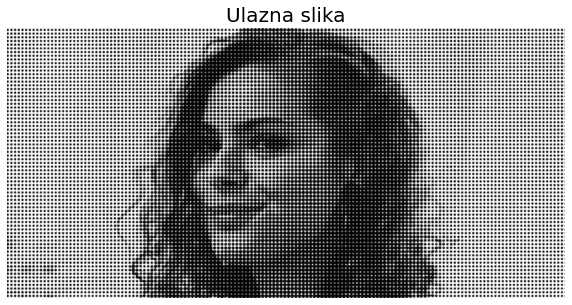

In [8]:
img = io.imread('sekvence/girl_ht.tif')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Ulazna slika nastala postupkom polutoniranja gde se štampanjem crnih i belih polja različite veličine ostvaruje utisak različitih nijansi sive.

Dimenzije slike

In [9]:
N = img.shape[0]  # N   rows    y
M = img.shape[1]  # M   columns x

Proširujemo sliku kako bismo dobili spektar veće rezolucije

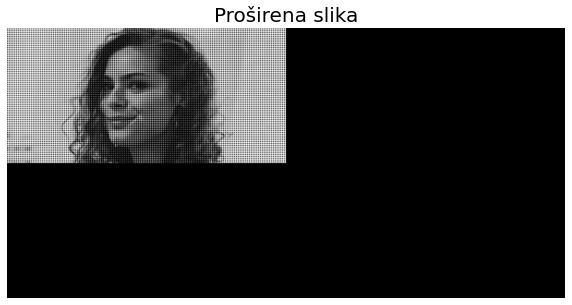

In [10]:
padded_img = np.zeros((2 * N, 2 * M))
Q = padded_img.shape[0]  # 2*N   rows    y
P = padded_img.shape[1]  # 2*M   columns x
padded_img[0:N, 0:M] = img

plt.figure(figsize=figsize)
plt.imshow(padded_img, cmap='gray')

plt.title('Proširena slika', fontsize=fontsize)
plt.axis('off')
plt.show()

### Analiza u frekvencijskom domenu

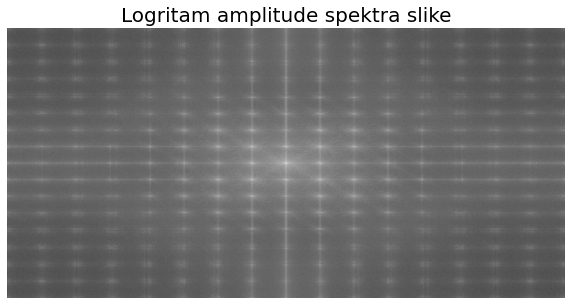

In [11]:
F = fftshift(fft2(padded_img))
log_abs_F = log_abs_F_foo(F)

plt.figure(figsize=figsize)
plt.imshow(log_abs_F, cmap='gray')

plt.title('Logritam amplitude spektra slike', fontsize=fontsize)
plt.axis('off')
plt.show()

Uočavamo veliki broj ravnomerno raspoređenih pikova u spektru i sumnjamo da oni potiču od tačkica čije prisustvo hoćemo da prikrijemo.

Prva stvar koju možemo da uradimo je da primenimo niskofrekventni filtar i da se otarasimo komponenti na jako visokim frekvencijama kako bismo smanjili broj pikova koji moramo da odstranimo.

In [12]:
H_lp = lowpass_filter('butter', (Q, P), D0=700, order=4, R=1000)
F_lowpassed = F * H_lp
log_abs_F_lowpassed = log_abs_F_foo(F_lowpassed)

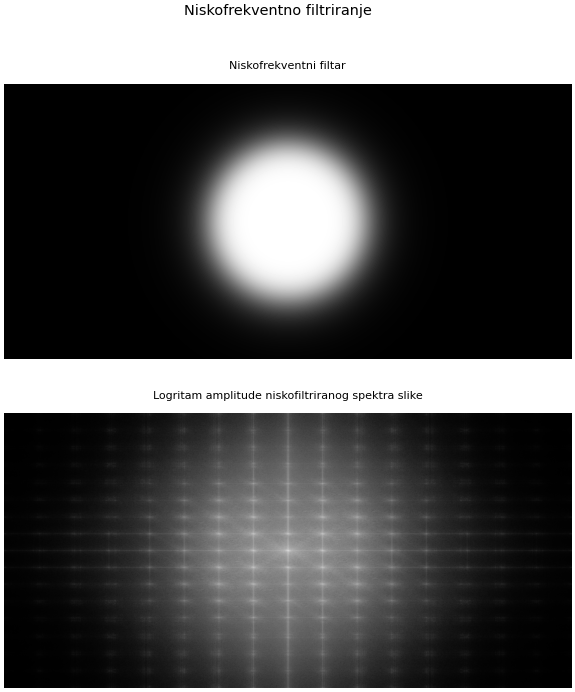

In [13]:
# subplot_figsize = (30, 8)
subplot_figsize = (20,20)
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);

suptitle_scale = 1.3

ax[0].imshow(H_lp, cmap='gray')
ax[0].set_title("Niskofrekventni filtar\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(log_abs_F_lowpassed, cmap='gray')
ax[1].set_title("Logritam amplitude niskofiltriranog spektra slike\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Niskofrekventno filtriranje", fontsize= suptitle_scale * fontsize)
plt.show()

# TODO Videti za velicinu fonta. 

Sledeće šta treba da uradimo je da lociramo vrhove spektra i da odstranimo sve osim onog koji odgovara DC komponenti.

In [14]:
peaks = peak_local_max(log_abs_F_lowpassed,
                       min_distance=100,
                       threshold_abs=0,
                       threshold_rel=0.3,
                       exclude_border=True,
                       indices=True,
                       num_peaks=np.inf,
                       footprint=None,
                       labels=None)


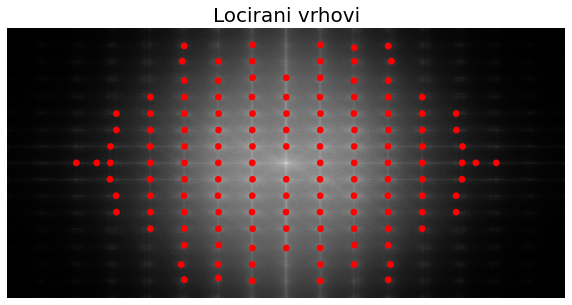

In [15]:
fig, ax = plt.subplots(1, figsize=figsize)
ax.imshow(log_abs_F_lowpassed, cmap='gray')

# crtanje krugova
dist_min = 50
for i in range(len(peaks)):
    if np.abs(peaks[i, 0] - Q / 2) < dist_min and np.abs(
            peaks[i, 1] - P / 2) < dist_min:
        continue
    circ = Circle((peaks[i, 1], peaks[i, 0]), 30,  facecolor='r')
    ax.add_patch(circ)

plt.title("Locirani vrhovi", fontsize=fontsize)
plt.axis('off')
plt.show()

In [16]:
x = np.arange(0, P, 1)
y = np.arange(0, Q, 1)

X, Y = np.meshgrid(x, y)

start_time = time.time()

radius = 250
D0 = radius / 3
order = 2
H_notch = notch_filter(filter_name='gauss', 
                 peaks=peaks, 
                 height=Q, 
                 width=P, 
                 radius=radius, 
                 D0=D0, 
                 order=order)

print("Vreme = " + "%.1f" % (time.time() - start_time) + " sec")

Vreme = 24.1 sec


In [17]:
F_notched = F_lowpassed * H_notch
log_abs_F_notched = log_abs_F_foo(F_notched)

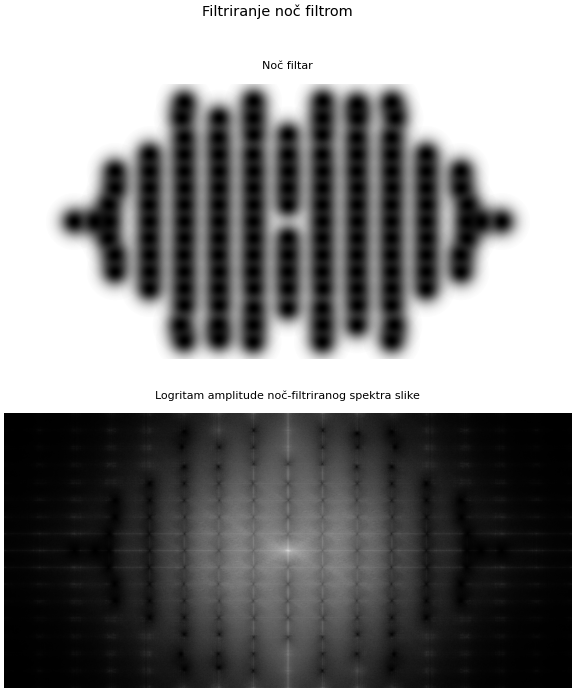

In [18]:
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);


ax[0].imshow(H_notch, cmap='gray')
ax[0].set_title("Noč filtar\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(log_abs_F_notched, cmap='gray')
ax[1].set_title("Logritam amplitude noč-filtriranog spektra slike\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Filtriranje noč filtrom", fontsize= suptitle_scale * fontsize)
plt.show()

Inverzna transformacija

In [19]:
img_filtered_padded = np.real(ifft2(ifftshift(F_notched)))
img_filtered = img_filtered_padded[0:N, 0:M]

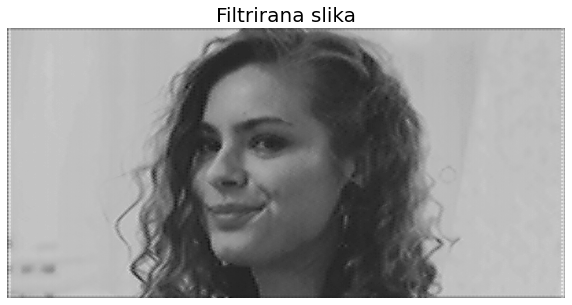

In [20]:
plt.figure(figsize=figsize)
plt.imshow(img_filtered, cmap='gray')

plt.title('Filtrirana slika', fontsize=fontsize)
plt.axis('off')
plt.show()

### Popravka kontrasta

In [21]:
hist_f, bin_edges = np.histogram(img_filtered.flatten(),
                                 bins=256, range=(np.amin(img_filtered), np.amax(img_filtered)))

Zasitimo piksele koji odgovaraju najvišem vrhu na maksimalnu vrednost jer oni odgovaraju pozadini. Zasitimo i određeni broj piksela na minimalnu vrednost radi boljeg kontrasta.

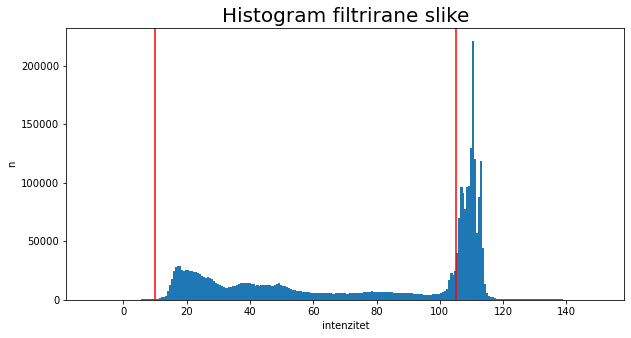

In [22]:
in_min = 10
in_max = 105

fig = plt.figure(figsize=(10, 5))
plt.bar(bin_edges[0:-1], hist_f)

fig.gca().axvline(x=in_min, color='r')
fig.gca().axvline(x=in_max, color='r')
plt.title('Histogram filtrirane slike', fontsize=fontsize)
plt.xlabel('intenzitet')
plt.ylabel('n')
plt.show()


In [23]:
img_contrast_stretched = np.array(img_filtered)

img_contrast_stretched[img_contrast_stretched < 15] = in_min
img_contrast_stretched[img_contrast_stretched > 200] = in_max

img_contrast_stretched = rescale_intensity(img_contrast_stretched,
                                           in_range=(in_min, in_max), out_range=(0, 255))

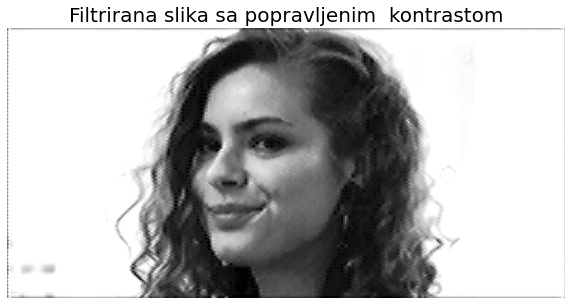

In [24]:
plt.figure(figsize=figsize)
plt.imshow(img_contrast_stretched, cmap='gray')

plt.title('Filtrirana slika sa popravljenim  kontrastom', fontsize=fontsize)
plt.axis('off')
plt.show()

### Poređenje

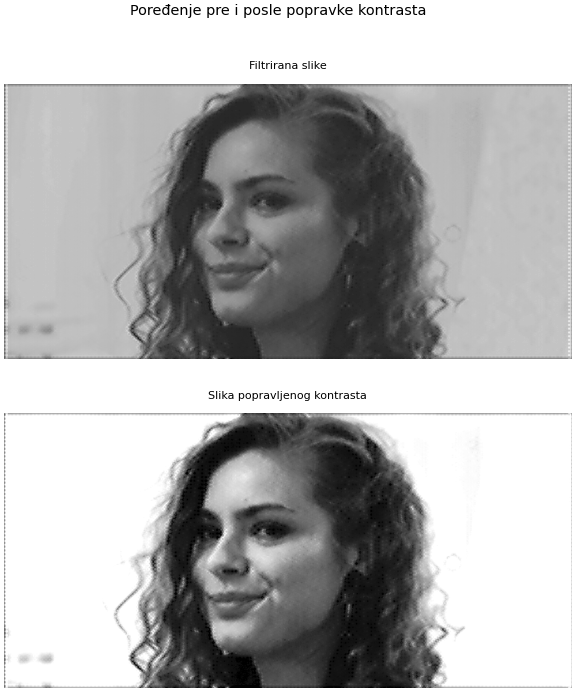

In [25]:
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);


ax[0].imshow(img_filtered, cmap='gray')
ax[0].set_title("Filtrirana slike\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(img_contrast_stretched, cmap='gray')
ax[1].set_title("Slika popravljenog kontrasta\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Poređenje pre i posle popravke kontrasta", fontsize= suptitle_scale * fontsize)
plt.show()

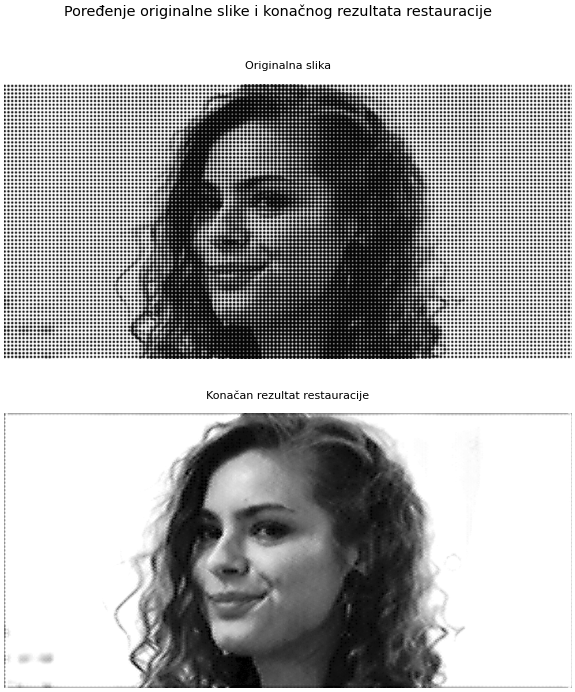

In [26]:
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);


ax[0].imshow(img, cmap='gray')
ax[0].set_title("Originalna slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(img_contrast_stretched, cmap='gray')
ax[1].set_title("Konačan rezultat restauracije\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Poređenje originalne slike i konačnog rezultata restauracije", fontsize= suptitle_scale * fontsize)
plt.show()

Apdejtovanje numerisanja jednačina

In [27]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## Drugi zadatak
<hr>

Automatsko numerisanje jednačina

In [28]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [29]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided
import time
from IPython.display import clear_output

from IPython.display import display, HTML

HTML centriranje plotova

In [30]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.

Matrica lokalnih susedstava - četvorodimenzionalni niz. Svaki element matrice je matrica koja predstavlja lokalno susedstvo jednog piksela slike. Iako izgleda kao da funkcija vraća novu matricu, zapravo vraća _pogled(view)_ na originalnu sliku takav da se može interpretirati kao matrica lokalnih susedstava i tako ne zauzimajući dodatnu memoriju koja bi morala biti pozamašna da to nije slučaj ($N \times M \times (2r + 1)^2 \times sizeof(pixel)$). Za više detalja pogledati prvi domaći zadatak.

In [31]:
def make_4d_array(arr_padded, r):
    N = arr_padded.shape[0] - 2 * r
    M = arr_padded.shape[1] - 2 * r

    # vracamo view na niz, samo ne kapiram zasto puta 2 strides
    return as_strided(arr_padded, shape=(N, M, 2 * r + 1, 2 * r + 1), strides=arr_padded.strides * 2)


Uvedimo funkciju $\omega (x, y)$ koju ćemo kasnije iskoristiti za adaptivno usrednjavanje slike.

\begin{equation} \label{omega_w}
\omega(x, y) = 
\begin{cases}
    \displaystyle\frac{\sigma_n^2}{\sigma_{S_{xy}}^2}, & \sigma_{S_{xy}}^2 \geq \sigma_n^2 \\ 
    1, & \sigma_{S_{xy}}^2 < \sigma_n^2       
\end{cases}
\end{equation}

gde je $(x, y)$ piksel sa koordinatama $x$ i $y$, $S_{xy}$ lokalno susedstvo piksela $(x, y)$, $\sigma_{S_{xy}}^2$ varijansa lokalnog susedstva $S_{xy}$, a $\sigma_n^2$ procenjena varijansa šuma. 

Ova funkcija ima niže vrednosti na mestima gde je varijansa lokalnog susedstva velika, dakle na ivicama, što omogućava čuvanje istih pri usrednjavanju.


In [32]:
def get_omega(img_double, img_var, noise_var):
    omega = np.ones_like(img_double)
    omega[img_var > noise_var] = noise_var / img_var[img_var > noise_var]
    return omega

Matrica varijansi svih lokalnih susedstava radijusa $r$ slike 

In [33]:
def get_local_vars(img_double, r):

    N = img_double.shape[0]  # N   rows    y
    M = img_double.shape[1]  # M   columns x
    
    padded_img = np.pad(img_double, [r, r], mode="edge")
    img_4d = make_4d_array(padded_img, r)  # matrica lokalnih susedstava

    img_var = np.zeros_like(img_double)

    for i in range(N):
        for j in range(M):
            img_var[i, j] = np.var(img_4d[i, j])
        # svaki 10. put ispisuje da ispis ne bi znacajno usporio izvrsavanje
        if (i % 10 == 0):
            clear_output(wait=True)
            print("%3.0f" % (i/N * 100), " %")

    clear_output(wait=True)   
    
    img_mean = np.einsum('ijkl->ij', img_4d) / (2 * r + 1) ** 2
    
    return img_var, img_mean

### Učitavanje

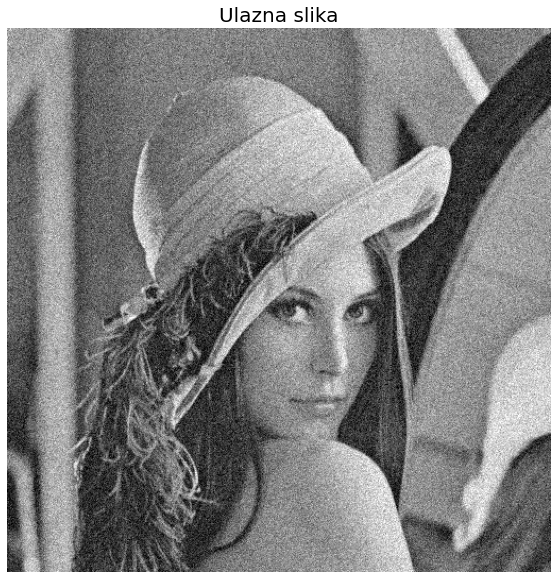

In [34]:
img = io.imread('sekvence/lena_noise.tif')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Dimenzije slike

In [35]:
N = img.shape[0]  # N   rows    y
M = img.shape[1]  # M   columns x

Proširivanje slike ponavljanjem ivičnih piksela. 

In [36]:
img_double = img / np.amax(img)

### Analiza varijansi lokalnih susedstava
Računanje varijansi za svako lokalno susedstvo.

Kako bismo izveli lokalno adaptivno usrednjavanje moramo proceniti varijansu šuma. Ovo činimo gledajući hisogram lokalnih varijansi slike. Ako se najveći broj piksela nalazi u uniformnim regionima slike onda će najveći broj susedstava imati baš varijansu šuma, dakle tražićemo maksimum histograma.

In [37]:
Rs = [2, 5, 10, 20]

In [38]:
img_vars = []

for r in Rs:
    img_var, _ = get_local_vars(img_double, r)
    img_vars.append(img_var)

100  %


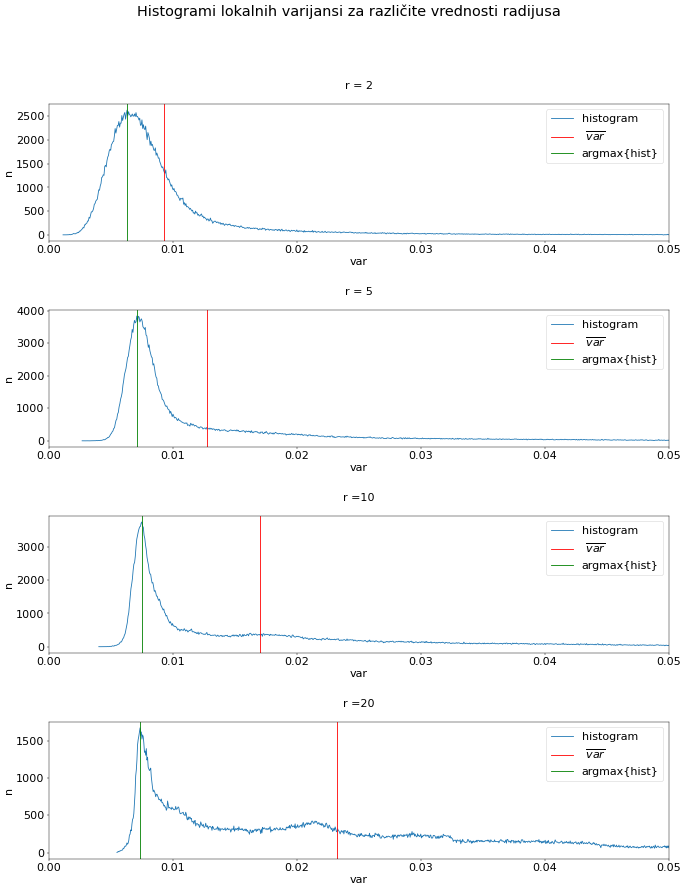

In [39]:
subplot_figsize = (20,25)

fig, ax = plt.subplots(len(Rs), 1, figsize=subplot_figsize, dpi=40);

fig.subplots_adjust(hspace=0.5)
suptitle_scale = 1.3

subplot_fontsize = 20

noise_var_argmax = []

for i, r in enumerate(Rs):
    hist_f, bin_edges = np.histogram(img_vars[i], bins=2000, range=(np.amin(img_vars[i]), np.amax(img_vars[i])))
    
    noise_var_argmax.append(bin_edges[np.argmax(hist_f)])
    
    ax[i].plot(bin_edges[0:-1], hist_f, label='histogram')
    ax[i].axvline(x=np.mean(img_vars[i]), color='r', label=" $\\overline{var}$")
    ax[i].axvline(x=bin_edges[np.argmax(hist_f)], color='green', label='argmax{hist}')
    
    ax[i].legend(fontsize=20)
    
    ax[i].tick_params(axis='both', which='major', labelsize=subplot_fontsize)
    
    ax[i].set_title('r =' + '%2.0d' % r + '\n', fontsize=subplot_fontsize)
    ax[i].set_xlabel('var', fontsize=subplot_fontsize)
    ax[i].set_ylabel('n', fontsize=subplot_fontsize)
    ax[i].set_xlim([0, 0.05])

fig.suptitle("Histogrami lokalnih varijansi za različite vrednosti radijusa", fontsize= suptitle_scale * fontsize)
plt.show()
    

Sa grafika vidimo da kako povećavamo radijus, glavni vrh histograma se sužava. Kao procenu varijanse šuma uzimamo varijansu na kojoj se javlja taj vrh.

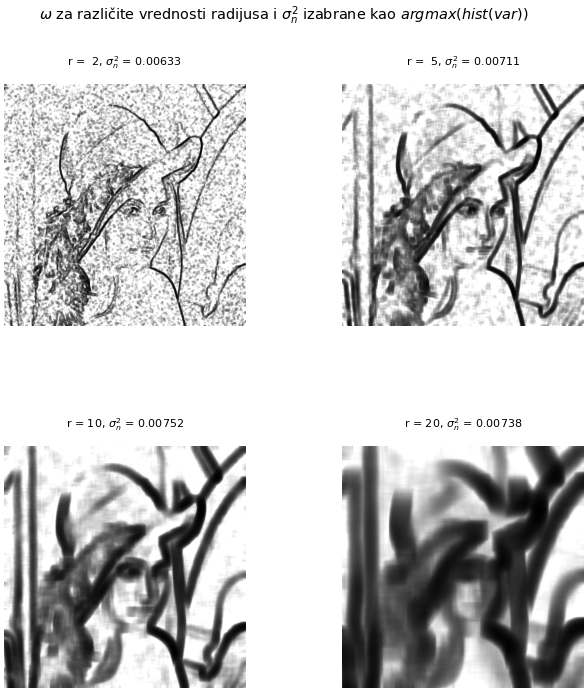

In [40]:
subplot_figsize = (20,20)

fig, ax = plt.subplots(2, 2, figsize=subplot_figsize, dpi=40);

fig.subplots_adjust(hspace=0.5)
suptitle_scale = 1.3

subplot_fontsize = 20

for i, r in enumerate(Rs):
    
    ax[i // 2, i % 2].imshow(get_omega(img_double, img_vars[i], noise_var_argmax[i]), cmap='gray')
    
    
    ax[i // 2, i % 2].set_title('r =' + '%3.0d' % r + ', $\sigma_n^2$ = ' + '%1.5f' % noise_var_argmax[i] + '\n', fontsize=subplot_fontsize)
    ax[i // 2, i % 2].axis('off')

fig.suptitle("$\omega$ za različite vrednosti radijusa i $\sigma_n^2$ izabrane kao $argmax(hist(var))$", fontsize= suptitle_scale * fontsize)
plt.show()
    

Ove vrednosti funkcije $w$ nisu ono što sam očekivao da ću dobiti. Za male vrednosti $r$ uniformni regioni neće biti očišćeni od šuma onoliko koliko bih voleo, a za veće vrednosti su oblasti ivica preširoke. Ne znam zašto je ovo slučaj ali zato predlažem drugi način.  
  
  
Ako zadržimo pretpostavku da se većina piksela slike nalazi u uniformnim regionima, što je ispunjeno za malo $r$, varijansu šuma možemo proceniti kao srednju vrednost svih varijansi lokalnih susedstava.

In [41]:
r = 3
img_var, img_mean = get_local_vars(img_double, r)

100  %


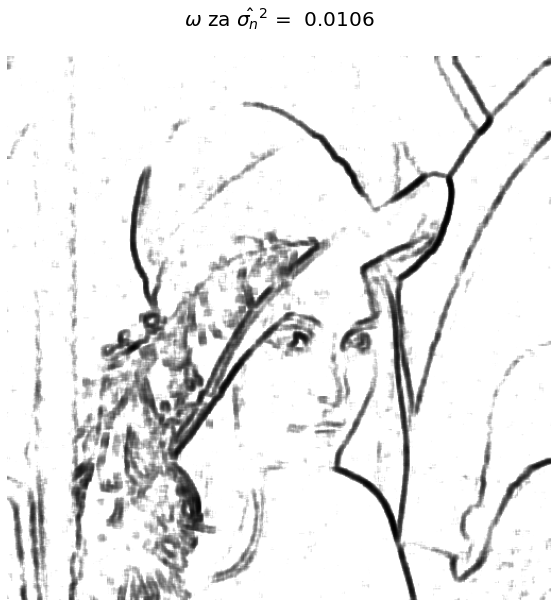

In [42]:
var_est_mean = np.mean(img_var)
omega = get_omega(img_double, img_var, var_est_mean)

plt.figure(figsize=figsize)
plt.imshow(omega, cmap='gray')

plt.title('$\omega$ za $\hat{\sigma_n}^2$ =  ' + "%.4f" % var_est_mean + '\n', fontsize=fontsize)
plt.axis('off')
plt.show()

### Filtriranje

Filtriranje zašumljene slike $g$ vrši se usrednjavanjem ali, pri tome davajući manju težinu oblastima koje obuhvataju ivice, a veću uniformnim regionima, posredstvom ranije određene funkcije $\omega$ date formulom (\ref{omega_w}). 

Filtriranu sliku, odnosno, procenu originalne slike $\hat{f}$ dobijamo sledećom formulom adaptivnog lokalnog usrednjavanja:


\begin{equation} \label{adaptivno_lokalno_usrednjavanje}
\hat{f}(x, y) = g(x, y) - \omega(x, y) \ (g(x,y) - \mu_{S_{xy}})
\end{equation}

gde je $\mu_{S_{xy}}$ srednja vrednost lokalnog susedstva $S_{xy}$.

In [43]:
var_est = var_est_mean
omega = get_omega(img_double, img_var, var_est)


img_filtered = img_double - omega * (img_double - img_mean)

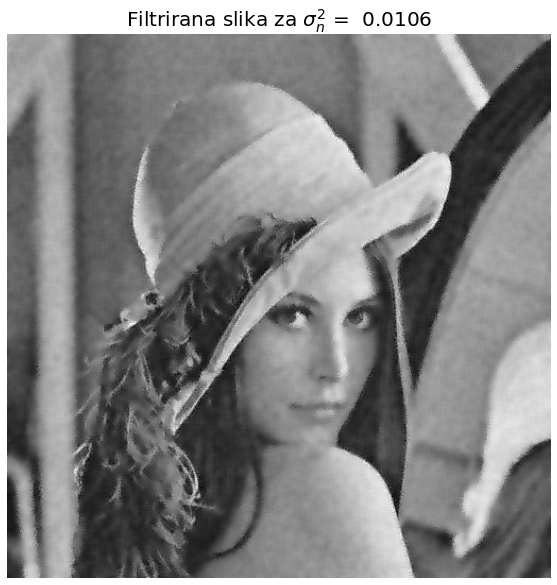

In [44]:
plt.figure(figsize=figsize)
plt.imshow(img_filtered, cmap='gray')

plt.title('Filtrirana slika za $\sigma_n^2$ =  ' + "%.4f" % var_est, fontsize=fontsize)
plt.axis('off')
plt.show()

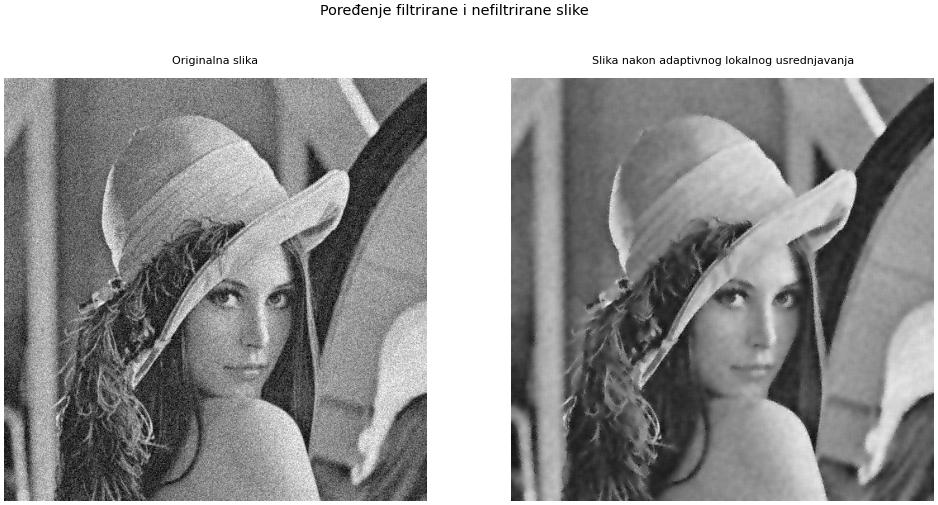

In [45]:
subplot_figsize = (30,15)

fig, ax = plt.subplots(1, 2, figsize=subplot_figsize, dpi=40);

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Originalna slika\n', fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(img_filtered, cmap='gray')
ax[1].set_title('Slika nakon adaptivnog lokalnog usrednjavanja\n', fontsize=fontsize)
ax[1].axis('off')



fig.suptitle("Poređenje filtrirane i nefiltrirane slike", fontsize= suptitle_scale * fontsize)

plt.show()

Filtrirana slika zaista deluje da ima manje šuma u uniformnim regionima, a da su ivice očuvane. Ako bolje pogledamo ivice možemo zaključiti, takođe, da one poseduju više šuma, što je posledica ovakvog selektivnog usrednjavanja.

Apdejtovanje numerisanja jednačina

In [46]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## Treći zadatak
<hr>

Automatsko numerisanje jednačina

In [47]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [48]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from numpy.lib.stride_tricks import as_strided
import time
from IPython.display import clear_output
from skimage.exposure import rescale_intensity
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
%matplotlib inline

from IPython.display import display, HTML

HTML centriranje plotova

In [49]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.



2D Gausova funkcija

\begin{equation} \label{gauss_2d}
H(x, y) = e^{\displaystyle-\frac{1}{2} \left(\frac{x^2}{D_x^2} + \frac{y^2}{D_y^2} \right)}
\end{equation}

gde su $D_x$ i $D_y$ disperzije po $x$, odnosno $y$ osi respektivno.

In [50]:
def gauss_2D_H(X, Y, Dx, Dy):
    return np.exp(-0.5*((X / Dx) ** 2 + (Y / Dy) ** 2))

Primena restauracije na bazi Vinerovog filtra na jednu (RGB) komponentu slike 
\begin{equation} \label{restauration_wiener}
\hat{F}(u, v) = \displaystyle\frac{|H(u, v)|^2}{|H(u, v)|^2 + K} \frac{G(u, v)}{H(u, v)}
\end{equation}

gde su $(u, v)$ prostorne koordinate slike, $\hat{F}$ procena spektra originalne slike, $G$ spektar ulazne slike, $H$ spektar degradacione funkcije, a $K$ podesiv parametar.

In [51]:
def apply_restoration(G, H, K):
    F_prim = G / H * (np.abs(H) ** 2 / (np.abs(H) ** 2 + K))
    return np.real(ifft2(ifftshift(F_prim)))

Primena restauracije na sve komponente slike

In [52]:
def apply_to_all(img_rgb_double, H, K):
    img_restored = np.zeros((N, M, 3))
    
    for i in range(3):
        G = fftshift(fft2(img_rgb_double[:, :, i]))
        img_restored[:, :, i] = apply_restoration(G, H, K)
    
    return img_restored

Prikaz spektra kao $log(1 + |F|)$

In [53]:
def log_abs_F_foo(F):
    return np.log(1 + np.abs(F))

### Učitavanje

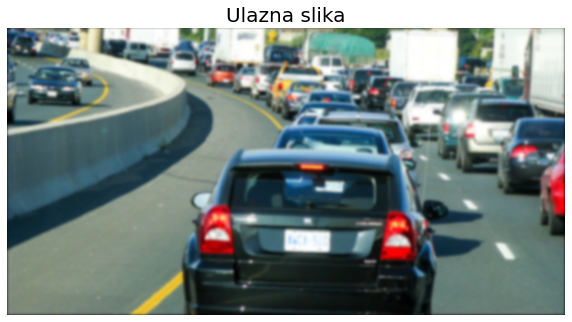

In [54]:
img_rgb = io.imread('sekvence/road_blur.png')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img_rgb, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Ulazna slika je očigledno zamućena, a kako je poznato da se zamućenje može opisati Gausovom funkcijom \ref{gauss_2d} i da jednako pogađa sve komponente (RGB) slike pokušaćemo procenimo disperzije Gausove funkcije po obe komponente - $x$ i $y$.

In [55]:
N = img_rgb.shape[0]  # N   rows    y
M = img_rgb.shape[1]  # M   columns x

img_rgb_double = img_rgb / 255

In [56]:
x = np.arange(0, M, 1)
y = np.arange(0, N, 1)

X, Y = np.meshgrid(x, y)

### Pronalaženje degradacione funkcije

Probanjem različitih vrednosti $D_x$, $D_y$ i $K$ dobijene su sledeće vrednosti koje daju dovoljno dobar rezlutat restauracije.

In [57]:
K = 5e-5
Dx = 60
Dy = 30

H = gauss_2D_H(X - M / 2, Y - N / 2, Dx=Dx, Dy=Dy)

Spektar degradacione funkcije

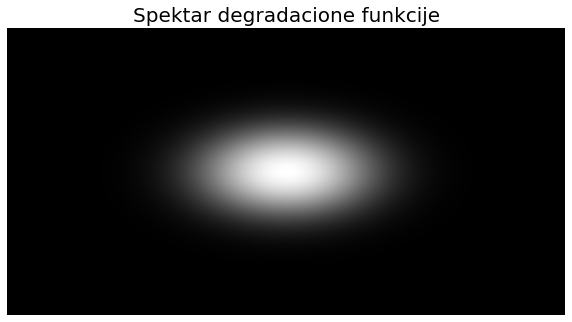

In [58]:
plt.figure(figsize=figsize)
plt.imshow(log_abs_F_foo(H), cmap='gray')

plt.title('Spektar degradacione funkcije', fontsize=fontsize)
plt.axis('off')
plt.show()

### Restauracija

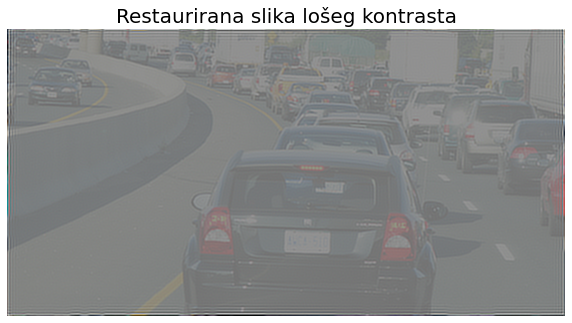

In [59]:
img_restored = apply_to_all(img_rgb_double, H, K)

img_restored -= np.amin(img_restored)
img_restored /= np.amax(img_restored)

plt.figure(figsize=figsize)
plt.imshow(img_restored)

plt.title('Restaurirana slika lošeg kontrasta', fontsize=fontsize)
plt.axis('off')
plt.show()

Iako je slika sada restaurirana, ona nije od velike koristi jer je jako lošeg kontrasta.  

Popravka kontrasta restaurirane slike

In [60]:
in_min = [110, 110, 110]  # opseg vrednosti piksela slike
in_max = [150, 150, 150]

img_restored_contrasted = np.zeros_like(img_restored)

for i in range(3):
#     hist_f, bin_edges = np.histogram(img_restored[:, :, i].flatten()*255,
#                                      bins=256, range=(0, 255))
    
#     plt.plot(bin_edges[0:-1], hist_f)
#     plt.show()
    img_contrast_stretched = np.array(img_restored[:, :, i] * 255)

    img_contrast_stretched[img_contrast_stretched < in_min[i]] = in_min[i]
    img_contrast_stretched[img_contrast_stretched > in_max[i]] = in_max[i]

    img_contrast_stretched = np.interp(img_contrast_stretched, [in_min[i], in_max[i]], [0, 255])

    
    img_restored_contrasted[:, :, i] = img_contrast_stretched
    

    

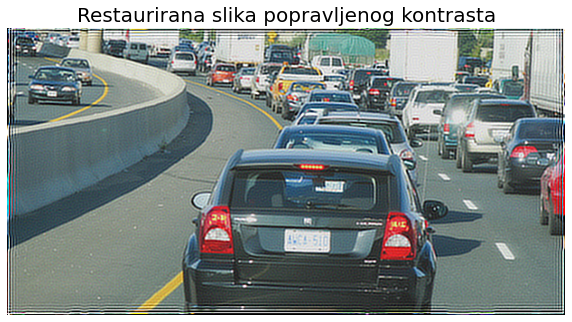

In [61]:
img_restored_contrasted = img_restored_contrasted.astype(np.uint8)
plt.figure(figsize=figsize)
plt.imshow(img_restored_contrasted)

plt.title('Restaurirana slika popravljenog kontrasta', fontsize=fontsize)
plt.axis('off')
plt.show()

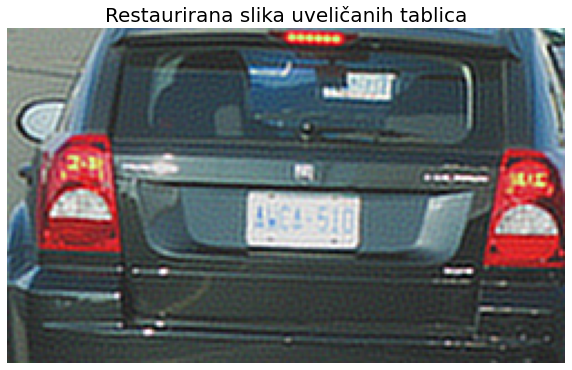

In [62]:
img_restored_contrasted = img_restored_contrasted.astype(np.uint8)
plt.figure(figsize=figsize)
plt.imshow(img_restored_contrasted[150:300, 200:450])

plt.title('Restaurirana slika uveličanih tablica', fontsize=fontsize)
plt.axis('off')
plt.show()

Sa slike se može razaznati registarski broj automobila **AWCA - 510**

Apdejtovanje numerisanja jednačina

In [63]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## Četvrti zadatak
<hr>

Automatsko numerisanje jednačina

In [64]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [65]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided
import time
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from IPython.core.display import HTML
from IPython.display import clear_output

%matplotlib inline

HTML centriranje plotova

In [66]:
out = display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.

Prostorni kernel Gausovog filtra

\begin{equation} \label{gauss_nf}
w(x, y) = \frac{e^{-\displaystyle\frac{D^2(x, y)}{2\sigma_s^2}}}{\sum_{i=-r}^r \sum_{j=-r}^r w(i, j)}
\end{equation}

$$
x, y \in [-r, r]
$$

gde su $(x, y)$ prostorne koordinate u kernelu $w$, $r$ radijus filtra, $D^2(x, y)$ kvadrat euklidskog rastojanja pozicije $(x, y)$ od koordinatnog početka dato formulom (\ref{euclid_distance}), a $\sigma_s$ standardna devijacije Gausove funkcije.

In [67]:
def spatial_kernel(r, sigma_s):
    A = np.arange(-r, r + 1)
    A = np.einsum("i,i->i", A, A)
    kernel = np.exp(-(np.tile(A, (2 * r + 1, 1)) + np.tile(A, (2 * r + 1, 1)).T) / (2 * sigma_s ** 2))
    return kernel / np.sum(kernel)

Matrica lokalnih susedstava kao u drugom zadatku

In [68]:
def make_4d_array(arr_padded, r):
    N = arr_padded.shape[0] - 2 * r
    M = arr_padded.shape[1] - 2 * r

    # vracamo view na niz, samo ne kapiram zasto puta 2 strides
    return as_strided(arr_padded, shape=(N, M, 2 * r + 1, 2 * r + 1), strides=arr_padded.strides * 2)

Isto kao i gore samo prepravljeno za kernele proizvoljnih dimenzija.

In [69]:
def make_4d_array_custom(arr_padded, N, M, a, b):
    
    return as_strided(arr_padded, shape=(N, M, a, b), strides=arr_padded.strides * 2)

Gausov filtar implementiran u prostornom domenu sa kvadratnom složenošću po $r$

In [70]:
def filter_gauss_r2(img, r, sigma):
    kernel = spatial_kernel(r, sigma)
    img_double = img / np.amax(img)

    padded_img = np.pad(img_double, [r, r], mode="edge")

    img_4d = make_4d_array(padded_img, r)

    img_filtered = np.einsum('ijkl, kl->ij', img_4d, kernel)

    return img_filtered

Gausov filtar implementiran u prostornom domenu sa linearnom složenošću po $r$

In [71]:
def filter_gauss(img, r, sigma):
    
    # ovo dobijanje komponenti može efikasnije sigurno. Čitao sam da se dobija preko paskalovog trougla efikasno.
    kernel = spatial_kernel(r, sigma)
    
    X = np.diag(kernel) ** (1/2)
    X = X.reshape((X.size, 1))
    
    wx = X.T
    wy = X
    
    # wx == wy
    w_horizontal = wx
    w_vertical = wy
    
    # ovo može da se prosledi
    img_double = img / np.amax(img)
    padded_sides = np.pad(img_double, ((0, 0), (r, r)), mode="edge")  # prosiruje sa strane jer prvo radimo horizontalni prolaz

    
    N = img_double.shape[0]
    M = img_double.shape[1]
    
    a = 1
    b = 2 * r + 1 # lokalno susedstvo (1 x 2r+1)
    
    # matrica jednodimenzionalnih lokalnih susedstava (1 x 2r+1)
    img_4d_horizontal = make_4d_array_custom(padded_sides, N, M, a, b)
    
    # slika filtrirana horizontalno
    horizontal_result = np.einsum('ijkl, kl->ij', img_4d_horizontal, w_horizontal)
    
    # sad tu filtriranu horizontalno pripremamo za vertikalno filtriranje
    padded_top_and_bottom = np.pad(horizontal_result, ((r, r), (0, 0)), mode="edge")  # prosirivanje gore i dole
    
    a = 2 * r + 1
    b = 1 # lokalno susedstvo (2r+1 x 1)
    
    # matrica jednodimenzionalnih lokalnih susedstava (1 x 2r+1)
    img_4d_vertical = make_4d_array_custom(padded_top_and_bottom, N, M, a, b)
    
    # slika filtrirana prvo horizontalno pa konacno i vertikalno, to i vracamo. Moze ovde samo return radi efikasnosti
    vertical_result = np.einsum('ijkl, kl->ij', img_4d_vertical, w_vertical)    
    
    return vertical_result
        

Gausov filtar implementiran preko Furijeove transformacije

In [72]:
def filter_gauss_freq(img, r, sigma):

    N = img.shape[0]
    M = img.shape[1]

    # kernel
    w = spatial_kernel(r, sigma)
    img_double = img / np.amax(img)
    
    # za prosirenje
    
    # rows
    before1 = 0
    after1 = N - w.shape[0]

    # columns
    before2 = 0
    after2 = M - w.shape[1]
    w_padded = np.pad(w, ((before1, after1), (before2, after2)), mode='constant', constant_values=0)

    # fft kernela
    W = fftshift(fft2(w_padded))
    # fft slike
    F = fftshift(fft2(img_double))

    # filtriranje u frekvencijskom domenu

    # ceo spektar se mnozi
    # F_filtered = F * W

    # TODO videti da l ovako treba
    # samo amplitudski
    F_filtered = F * np.abs(W)

    # ifft filtriranje slike
    return np.real(ifft2(ifftshift(F_filtered)))

In [73]:
def filter_gauss_freq_prosirivanje(img, r, sigma):
    N = img.shape[0] * 2
    M = img.shape[1] * 2

    # kernel
    w = spatial_kernel(r, sigma)
    img_double = img / np.amax(img)
    
    # za prosirenje
    # rows
    before1 = 0
    after1 = N - w.shape[0]

    # columns
    before2 = 0
    after2 = M - w.shape[1]

    w_padded = np.pad(w, ((before1, after1), (before2, after2)), mode='constant', constant_values=0)
    
    before1 = np.int(N/4)
    after1 = before1
    
    before2 = np.int(M/4)
    after2 = before2
    
    padded_img = np.pad(img_double, ((before1, after1), (before2, after2)), mode='symmetric')
    
    # fft kernela
    W = fftshift(fft2(w_padded))
    
    # fft slike
    F = fftshift(fft2(padded_img))

    # filtriranje u frekvencijskom domenu

    # ceo spektar se mnozi
    # F_filtered = F * W

    # TODO videti da l ovako treba
    # samo amplitudski
    F_filtered = F * np.abs(W)
    # ifft filtriranje slike
    
    filtered_img = np.real(ifft2(ifftshift(F_filtered)))
    return filtered_img[before1:-after1, before2:-after2]

### Učitavanje

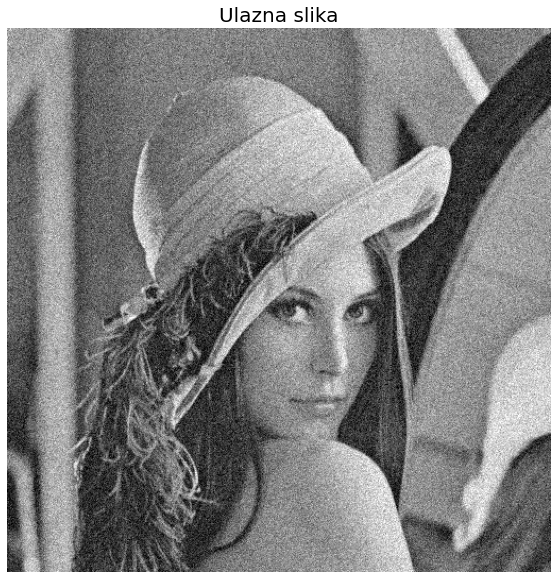

In [74]:
img = io.imread('sekvence/lena_noise.tif')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Parametri filtra

In [75]:
r = 30
sigma = r/3

Gauov filtar implementiran u prostornom domenu sa složenošću $\mathcal{O}(r)$

In [76]:
# r
start_time = time.time()

img_filtered_lin = filter_gauss(img, r, sigma)

print("lin --- %s seconds ---" % (time.time() - start_time))

lin --- 0.02348041534423828 seconds ---


Gauov filtar implementiran u prostornom domenu sa složenošću $\mathcal{O}(r^2)$

In [77]:
# r^2
start_time = time.time()

img_filtered_r2 = filter_gauss_r2(img, r, sigma)

print("r2 --- %s seconds ---" % (time.time() - start_time))

r2 --- 0.5516238212585449 seconds ---


Gausov filtar implementiran u frekvencijskom domenu sa složenošću $\mathcal{O}(1)$ u odnosu na $r$

In [78]:
# fft
start_time = time.time()

img_filtered_freq = filter_gauss_freq(img, r, sigma)

print("fft --- %s seconds ---" % (time.time() - start_time))

fft --- 0.034961700439453125 seconds ---


Gausov filtar implementiran u frekvencijskom domenu sa simetričnim proširivanjem slike

In [79]:
# fft ogledalo
start_time = time.time()

img_filtered_freq_prosireno = filter_gauss_freq_prosirivanje(img, r, sigma)

print("freq prosireno --- %s seconds ---" % (time.time() - start_time))

freq prosireno --- 0.15233659744262695 seconds ---


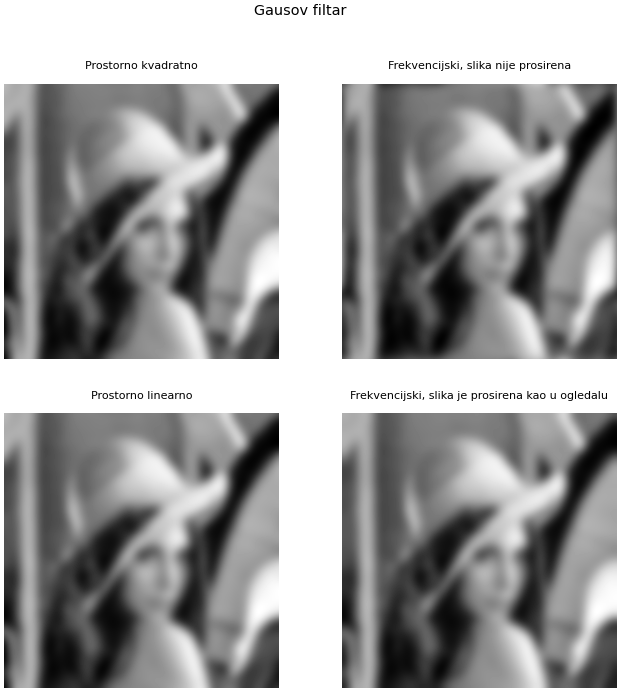

In [80]:
subplot_figsize = (20,20)
fig, ax = plt.subplots(2, 2, figsize=subplot_figsize, dpi=40);

suptitle_scale = 1.3

ax[0, 0].imshow(img_filtered_r2, cmap='gray')
ax[0, 0].set_title("Prostorno kvadratno\n", fontsize=fontsize)
ax[0, 0].axis('off')

ax[0, 1].imshow(img_filtered_freq, cmap='gray')
ax[0, 1].set_title("Frekvencijski, slika nije prosirena\n", fontsize=fontsize)
ax[0, 1].axis('off')

ax[1, 0].imshow(img_filtered_lin, cmap='gray')
ax[1, 0].set_title("Prostorno linearno\n", fontsize=fontsize)
ax[1, 0].axis('off')

ax[1, 1].imshow(img_filtered_freq_prosireno, cmap='gray')
ax[1, 1].set_title("Frekvencijski, slika je prosirena kao u ogledalu\n", fontsize=fontsize)
ax[1, 1].axis('off')

fig.suptitle("Gausov filtar", fontsize= suptitle_scale * fontsize)
plt.show()


Proširivanje kao u ogledalu očigledno rešava problem tamnih ivica koji se javlja kada ne proširujemo jer tada algoritam podrazumeva da je slika proširena nulama.

### Poređenje brzina izvršavanja

In [81]:
r_array = np.arange(1, 51)
t_spatial = np.zeros_like(r_array, dtype=np.float32)
t_freq = np.zeros_like(r_array, dtype=np.float32)

# freq prosiren nulama
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss_freq(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_freq[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")
    
# prostorni lin
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_spatial[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")

100  %


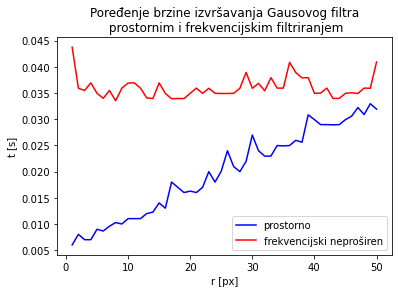

In [82]:
plt.figure()
plt.plot(r_array, t_spatial, label='prostorno', color='blue')
plt.plot(r_array, t_freq, label='frekvencijski neproširen', color='red')

plt.title("Poređenje brzine izvršavanja Gausovog filtra\n prostornim i frekvencijskim filtriranjem")
plt.xlabel('r [px]')
plt.ylabel('t [s]')
plt.legend()
plt.show()

Kako je složenost funkcije u frekvencijskom domenu konstantna u odnosu na radijus filtra, za razliku od funkcije u prostornom domenu čija je složenost linearna, ima smisla koristiti frekvencijski domen za velike prostorne maske, a prostorni domen za male.

In [83]:
t_spatial_r2 = np.zeros_like(r_array, dtype=np.float32)
t_freq_prosireno = np.zeros_like(r_array, dtype=np.float32)

# freq prosiren u ogledalu
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss_freq_prosirivanje(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_freq_prosireno[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")
    
# prostorni r2
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss_r2(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_spatial_r2[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")

100  %


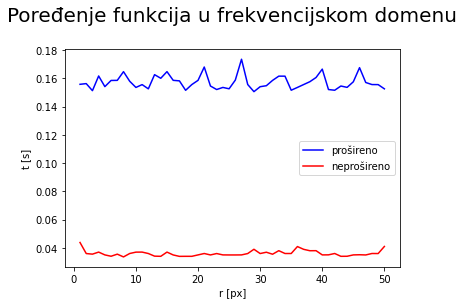

In [84]:
plt.figure()

plt.plot(r_array, t_freq_prosireno, label='prošireno', color='blue')
plt.plot(r_array, t_freq, label='neprošireno', color='red')
plt.title("Poređenje funkcija u frekvencijskom domenu\n", fontsize=fontsize)
plt.xlabel('r [px]')
plt.ylabel('t [s]')
plt.axis('on')
plt.legend()
plt.show()

Iako je filtriranje u frekvencijskom domenu nezavisno od $r$, vreme izvršavanje je ipak proporcionalno proizvodu širine i visine slike. Kako pri proširivanu dobijamo dva puta širu i dva puta višu sliku, tako je i vreme izvršavanja oko četiri puta veće i to je cena koju plaćamo kako ne bismo imali tamnije ivice posle filtriranja slike.

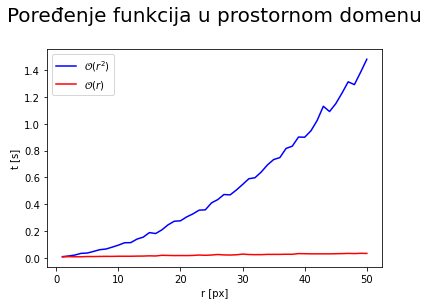

In [85]:
plt.figure()

plt.plot(r_array, t_spatial_r2, label='$\mathcal{O}(r^2)$', color='blue')
plt.plot(r_array, t_spatial, label='$\mathcal{O}(r)$', color='red')
plt.title("Poređenje funkcija u prostornom domenu\n", fontsize=fontsize)
plt.xlabel('r [px]')
plt.ylabel('t [s]')
plt.axis('on')
plt.legend()
plt.show()

Na poslednjoj slici vidimo značaj separabilnosti po dimenzijama prostornog kernela Gausovog filtra. 

Apdejtovanje numerisanja jednačina

In [86]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>